In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from dm_control import mjcf
from dm_control.rl.control import PhysicsError
import imageio
import scipy.spatial
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image

from flygym.arena.mujoco_arena import FlatTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb

from rl_navigation import ObstacleOdorArena, NMFNavigation

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site

In [3]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(10, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[20, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
)
sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)
# env_checker.check_env(sim)

In [4]:
# from flygym.util.vision import hex_pxls_to_human_readable

terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1.5,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)
sim = NMFNavigation(
    spawn_pos=(7.5, -10, 0.2),
    spawn_orient=(0, 0, np.pi/4),
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(15):
    action = np.array([0 if i < 10 else 0.6])
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    # fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # for i in range(2):
    #     visual_inputs = sim.curr_visual_input[i, :, :]
    #     print(visual_inputs.shape, visual_inputs.max())
    #     visual_inputs[:, 1] = 0
    #     visual_inputs[:, 0][visual_inputs[:, 0] > 50] = 0
    #     img = hex_pxls_to_human_readable(visual_inputs)
    #     axs[i].imshow(img, cmap="gray", vmin=0, vmax=255)
    #     axs[i].axis("off")
    # plt.show()
    
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video("test2.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


resetting environment


  7%|▋         | 1/15 [00:01<00:16,  1.17s/it]

fly_pos: [  7.57543747 -10.19910189], final reward=2.3846994483403154, state=seeking
  dist rew=2.384699, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=12.615


 13%|█▎        | 2/15 [00:02<00:18,  1.45s/it]

fly_pos: [  7.86152632 -10.73489144], final reward=-0.2763905945100653, state=seeking
  dist rew=-0.276391, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=12.892


 20%|██        | 3/15 [00:04<00:17,  1.47s/it]

fly_pos: [  8.14763683 -11.12413816], final reward=-0.17358079010299754, state=seeking
  dist rew=-0.173581, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.065


 27%|██▋       | 4/15 [00:05<00:15,  1.43s/it]

fly_pos: [  8.36792316 -11.37625891], final reward=-0.10301230804084938, state=seeking
  dist rew=-0.103012, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.168


 33%|███▎      | 5/15 [00:06<00:13,  1.36s/it]

fly_pos: [  8.70731685 -11.84948076], final reward=-0.24842382627927506, state=seeking
  dist rew=-0.248424, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.417


 40%|████      | 6/15 [00:08<00:11,  1.31s/it]

fly_pos: [  9.22033934 -12.29405855], final reward=-0.1681494173743694, state=seeking
  dist rew=-0.168149, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=13.585


 47%|████▋     | 7/15 [00:09<00:10,  1.28s/it]

fly_pos: [  9.38799803 -12.92256605], final reward=-0.5036938734110041, state=seeking
  dist rew=-0.503694, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=14.089


 53%|█████▎    | 8/15 [00:10<00:08,  1.22s/it]

fly_pos: [  9.8195547  -13.34944925], final reward=-0.23083440891201157, state=seeking
  dist rew=-0.230834, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=14.319


 60%|██████    | 9/15 [00:11<00:07,  1.21s/it]

fly_pos: [ 10.10790783 -13.88177461], final reward=-0.3754920298882807, state=seeking
  dist rew=-0.399182, danger=0.000, action diff=0.000, tgt rew=0.024
  dist=14.719


 67%|██████▋   | 10/15 [00:12<00:05,  1.18s/it]

fly_pos: [ 10.51925518 -14.52630238], final reward=-0.48309463704928746, state=seeking
  dist rew=-0.483095, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=15.202


 73%|███████▎  | 11/15 [00:13<00:04,  1.20s/it]

fly_pos: [ 10.80735967 -14.72602491], final reward=-0.13337741681332344, state=seeking
  dist rew=-0.109577, danger=0.000, action diff=0.300, tgt rew=0.276
  dist=15.311


 80%|████████  | 12/15 [00:15<00:03,  1.22s/it]

fly_pos: [ 10.28056485 -15.32343462], final reward=-0.5225252403628124, state=seeking
  dist rew=-0.722498, danger=0.000, action diff=0.000, tgt rew=0.200
  dist=16.034


 87%|████████▋ | 13/15 [00:16<00:02,  1.19s/it]

fly_pos: [ 10.43157332 -15.32706615], final reward=0.336926374742309, state=seeking
  dist rew=0.040317, danger=0.000, action diff=0.000, tgt rew=0.297
  dist=15.993


 93%|█████████▎| 14/15 [00:17<00:01,  1.16s/it]

fly_pos: [ 10.17573172 -15.79048914], final reward=-0.2488120474405504, state=seeking
  dist rew=-0.517580, danger=0.000, action diff=0.000, tgt rew=0.269
  dist=16.511


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]

fly_pos: [  9.73814002 -15.84696243], final reward=0.10933315846900582, state=seeking
  dist rew=-0.186706, danger=0.000, action diff=0.000, tgt rew=0.296
  dist=16.698


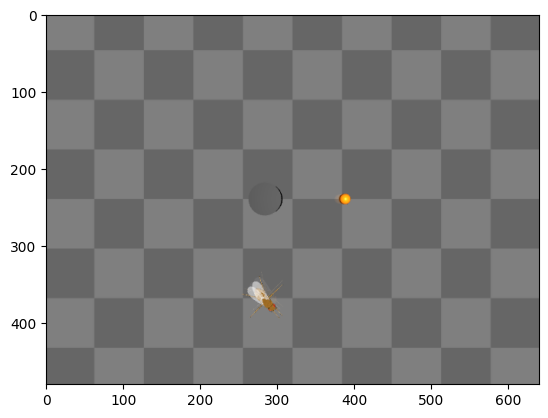

In [5]:
plt.imshow(sim._frames[0])

Logging to logs/trial_8
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
resetting environment


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

fly_pos: [ 0.11603922 -0.06244214], final reward=0.03316382083537128, state=seeking
  dist rew=0.115908, danger=0.000, action diff=0.083, tgt rew=0.000
  dist=14.884


  2%|▏         | 2/100 [00:03<02:27,  1.50s/it]

fly_pos: [ 0.64376072 -0.28918812], final reward=0.3967012508055312, state=seeking
  dist rew=0.524940, danger=0.000, action diff=0.128, tgt rew=0.000
  dist=14.359


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

fly_pos: [ 1.05960813 -0.23280161], final reward=0.4030492834015096, state=seeking
  dist rew=0.416816, danger=0.000, action diff=0.014, tgt rew=0.000
  dist=13.942


  4%|▍         | 4/100 [00:05<02:16,  1.42s/it]

fly_pos: [ 1.4828126  -0.24636941], final reward=0.29814207374410095, state=seeking
  dist rew=0.422903, danger=0.000, action diff=0.125, tgt rew=0.000
  dist=13.519


  5%|▌         | 5/100 [00:07<02:09,  1.37s/it]

fly_pos: [ 1.80055045 -0.66983647], final reward=0.2356714135663811, state=seeking
  dist rew=0.302998, danger=0.000, action diff=0.067, tgt rew=0.000
  dist=13.216


  6%|▌         | 6/100 [00:08<02:10,  1.39s/it]

fly_pos: [ 2.11925603 -0.63185836], final reward=0.2076428037177802, state=seeking
  dist rew=0.320202, danger=0.000, action diff=0.113, tgt rew=0.000
  dist=12.896


  7%|▋         | 7/100 [00:09<02:08,  1.38s/it]

fly_pos: [ 2.70888859 -0.96995992], final reward=0.5312458111239806, state=seeking
  dist rew=0.566908, danger=0.000, action diff=0.036, tgt rew=0.000
  dist=12.329


  8%|▊         | 8/100 [00:11<02:03,  1.35s/it]

fly_pos: [ 2.9602342  -0.99205653], final reward=0.2337080112973844, state=seeking
  dist rew=0.248756, danger=0.000, action diff=0.015, tgt rew=0.000
  dist=12.081


  9%|▉         | 9/100 [00:12<02:04,  1.37s/it]

fly_pos: [ 3.28957647 -1.11829308], final reward=0.3107371364001583, state=seeking
  dist rew=0.316870, danger=0.000, action diff=0.006, tgt rew=0.000
  dist=11.764


 10%|█         | 10/100 [00:13<01:59,  1.32s/it]

fly_pos: [ 3.72776248 -1.56731628], final reward=0.21650814522538653, state=seeking
  dist rew=0.383021, danger=0.000, action diff=0.167, tgt rew=0.000
  dist=11.381


 11%|█         | 11/100 [00:15<01:57,  1.32s/it]

fly_pos: [ 4.14501202 -1.59428582], final reward=0.2953968934584488, state=seeking
  dist rew=0.409237, danger=0.000, action diff=0.114, tgt rew=0.000
  dist=10.971


 12%|█▏        | 12/100 [00:16<01:55,  1.32s/it]

fly_pos: [ 4.69514289 -1.9775992 ], final reward=0.3744525494829869, state=seeking
  dist rew=0.478539, danger=0.000, action diff=0.104, tgt rew=0.000
  dist=10.493


 13%|█▎        | 13/100 [00:17<01:52,  1.30s/it]

fly_pos: [ 4.97343385 -2.04652115], final reward=0.23917757978734677, state=seeking
  dist rew=0.259609, danger=0.000, action diff=0.020, tgt rew=0.000
  dist=10.233


 14%|█▍        | 14/100 [00:19<01:58,  1.37s/it]

fly_pos: [ 5.13604597 -1.84222239], final reward=0.18520678462169649, state=seeking
  dist rew=0.198784, danger=0.000, action diff=0.014, tgt rew=0.000
  dist=10.035


 15%|█▌        | 15/100 [00:20<01:46,  1.26s/it]

fly_pos: [ 5.02370257 -1.70592458], final reward=-0.11285880277228166, state=seeking
  dist rew=-0.086592, danger=0.000, action diff=0.026, tgt rew=0.000
  dist=10.121


 16%|█▌        | 16/100 [00:21<01:41,  1.20s/it]

fly_pos: [ 5.04912244 -2.44673979], final reward=-0.16374340903777984, state=seeking
  dist rew=-0.126167, danger=0.000, action diff=0.038, tgt rew=0.000
  dist=10.247


 17%|█▋        | 17/100 [00:22<01:38,  1.18s/it]

fly_pos: [ 4.89836408 -3.4450613 ], final reward=-0.6973322341240884, state=seeking
  dist rew=-0.425665, danger=0.000, action diff=0.272, tgt rew=0.000
  dist=10.673


 18%|█▊        | 18/100 [00:23<01:40,  1.22s/it]

fly_pos: [ 5.26208411 -3.6236991 ], final reward=0.1191371854095511, state=seeking
  dist rew=0.282639, danger=0.000, action diff=0.164, tgt rew=0.000
  dist=10.390


 19%|█▉        | 19/100 [00:24<01:39,  1.23s/it]

fly_pos: [ 5.19156977 -3.77898291], final reward=-0.13722080291451455, state=seeking
  dist rew=-0.120939, danger=0.000, action diff=0.016, tgt rew=0.000
  dist=10.511


 20%|██        | 20/100 [00:26<01:41,  1.27s/it]

fly_pos: [ 4.54775642 -3.64727243], final reward=-0.5811521225304972, state=seeking
  dist rew=-0.559087, danger=0.000, action diff=0.022, tgt rew=0.000
  dist=11.070


 21%|██        | 21/100 [00:27<01:36,  1.22s/it]

fly_pos: [ 5.06482096 -3.89751829], final reward=0.37915085846907104, state=seeking
  dist rew=0.398000, danger=0.000, action diff=0.019, tgt rew=0.000
  dist=10.672


 22%|██▏       | 22/100 [00:28<01:36,  1.24s/it]

fly_pos: [ 5.25022671 -3.85086527], final reward=0.1799331616683535, state=seeking
  dist rew=0.189609, danger=0.000, action diff=0.010, tgt rew=0.000
  dist=10.483


 23%|██▎       | 23/100 [00:30<01:39,  1.30s/it]

fly_pos: [ 5.92154087 -4.10546044], final reward=0.46798879808608795, state=seeking
  dist rew=0.519117, danger=0.000, action diff=0.051, tgt rew=0.000
  dist=9.964


 24%|██▍       | 24/100 [00:31<01:35,  1.26s/it]

fly_pos: [ 6.02213355 -4.04004051], final reward=0.06472158666248085, state=seeking
  dist rew=0.118596, danger=0.000, action diff=0.054, tgt rew=0.000
  dist=9.845


 25%|██▌       | 25/100 [00:32<01:36,  1.29s/it]

fly_pos: [ 5.68765795 -4.20195309], final reward=-0.3872030073042616, state=seeking
  dist rew=-0.371464, danger=0.000, action diff=0.016, tgt rew=0.000
  dist=10.216


 26%|██▌       | 26/100 [00:33<01:33,  1.26s/it]

fly_pos: [ 6.22840432 -4.29101428], final reward=0.434249626885844, state=seeking
  dist rew=0.451542, danger=0.000, action diff=0.017, tgt rew=0.000
  dist=9.765


 27%|██▋       | 27/100 [00:35<01:34,  1.30s/it]

fly_pos: [ 6.29081722 -4.13950657], final reward=0.09254097521700544, state=seeking
  dist rew=0.122029, danger=0.000, action diff=0.029, tgt rew=0.000
  dist=9.643


 28%|██▊       | 28/100 [00:36<01:41,  1.41s/it]

fly_pos: [ 7.04513082 -3.95823781], final reward=0.7474225753432311, state=seeking
  dist rew=0.757647, danger=0.000, action diff=0.010, tgt rew=0.000
  dist=8.885


 29%|██▉       | 29/100 [00:38<01:36,  1.36s/it]

fly_pos: [ 6.85727548 -3.92156008], final reward=-0.16733792319690544, state=seeking
  dist rew=-0.152597, danger=0.000, action diff=0.015, tgt rew=0.000
  dist=9.038


 30%|███       | 30/100 [00:39<01:34,  1.35s/it]

fly_pos: [ 6.77922755 -4.17481287], final reward=-0.2047055892517431, state=seeking
  dist rew=-0.182253, danger=0.000, action diff=0.022, tgt rew=0.000
  dist=9.220


 31%|███       | 31/100 [00:40<01:31,  1.33s/it]

fly_pos: [ 6.97957559 -3.95832994], final reward=-0.42441111591512914, state=seeking
  dist rew=0.276071, danger=0.000, action diff=0.700, tgt rew=0.000
  dist=8.944


 32%|███▏      | 32/100 [00:42<01:29,  1.32s/it]

fly_pos: [ 7.13777931 -3.74043503], final reward=-0.5000846476804632, state=seeking
  dist rew=0.237397, danger=0.000, action diff=0.737, tgt rew=0.000
  dist=8.707


 33%|███▎      | 33/100 [00:43<01:28,  1.31s/it]

fly_pos: [ 7.03808803 -3.92534491], final reward=-0.8994017791469808, state=seeking
  dist rew=-0.170330, danger=0.000, action diff=0.729, tgt rew=0.000
  dist=8.877


 34%|███▍      | 34/100 [00:44<01:22,  1.25s/it]

fly_pos: [ 7.30516632 -3.6156099 ], final reward=-0.4152333094561058, state=seeking
  dist rew=0.375011, danger=0.000, action diff=0.790, tgt rew=0.000
  dist=8.502


 35%|███▌      | 35/100 [00:45<01:22,  1.27s/it]

fly_pos: [ 7.34683378 -3.3871091 ], final reward=-0.6772327303171828, state=seeking
  dist rew=0.132750, danger=0.000, action diff=0.810, tgt rew=0.000
  dist=8.369


 36%|███▌      | 36/100 [00:47<01:24,  1.32s/it]

fly_pos: [ 7.49355918 -3.72763859], final reward=-0.7561356218209525, state=seeking
  dist rew=-0.011850, danger=0.000, action diff=0.744, tgt rew=0.000
  dist=8.381


 37%|███▋      | 37/100 [00:48<01:20,  1.28s/it]

fly_pos: [ 7.96508049 -3.41332014], final reward=0.44177906783595766, state=seeking
  dist rew=0.561785, danger=0.000, action diff=0.120, tgt rew=0.000
  dist=7.819


 38%|███▊      | 38/100 [00:49<01:21,  1.31s/it]

fly_pos: [ 8.42563168 -3.40747165], final reward=0.3734731068567587, state=seeking
  dist rew=0.414318, danger=0.000, action diff=0.041, tgt rew=0.000
  dist=7.405


 39%|███▉      | 39/100 [00:51<01:21,  1.33s/it]

fly_pos: [ 8.98307775 -3.13336941], final reward=0.5441030874045998, state=seeking
  dist rew=0.621039, danger=0.000, action diff=0.077, tgt rew=0.000
  dist=6.784


 40%|████      | 40/100 [00:52<01:23,  1.39s/it]

fly_pos: [ 9.17828022 -3.1153323 ], final reward=0.14513417195508183, state=seeking
  dist rew=0.181048, danger=0.000, action diff=0.036, tgt rew=0.000
  dist=6.603


 41%|████      | 41/100 [00:54<01:23,  1.41s/it]

fly_pos: [ 9.49564966 -2.99693705], final reward=0.22374221682812934, state=seeking
  dist rew=0.335520, danger=0.000, action diff=0.112, tgt rew=0.000
  dist=6.267


 42%|████▏     | 42/100 [00:55<01:22,  1.43s/it]

fly_pos: [ 9.82889323 -2.72273021], final reward=0.19894723315189022, state=seeking
  dist rew=0.423228, danger=0.000, action diff=0.224, tgt rew=0.000
  dist=5.844


 43%|████▎     | 43/100 [00:57<01:21,  1.43s/it]

fly_pos: [10.16643784 -2.53392191], final reward=0.29523229849733124, state=seeking
  dist rew=0.386629, danger=0.000, action diff=0.091, tgt rew=0.000
  dist=5.457


 44%|████▍     | 44/100 [00:58<01:20,  1.43s/it]

fly_pos: [10.68305467 -2.12597987], final reward=0.4053008140626654, state=seeking
  dist rew=0.645431, danger=0.000, action diff=0.313, tgt rew=0.000
  dist=4.812


 45%|████▌     | 45/100 [00:59<01:17,  1.40s/it]

fly_pos: [10.9456685  -2.11523388], final reward=0.27099149838279196, state=seeking
  dist rew=0.239104, danger=0.000, action diff=0.029, tgt rew=0.000
  dist=4.573


 46%|████▌     | 46/100 [01:01<01:13,  1.37s/it]

fly_pos: [11.41381665 -1.89376629], final reward=0.7680303535282418, state=seeking
  dist rew=0.517446, danger=0.000, action diff=0.043, tgt rew=0.000
  dist=4.055


 47%|████▋     | 47/100 [01:02<01:10,  1.33s/it]

fly_pos: [11.7868384  -1.75002852], final reward=0.6496522240977866, state=seeking
  dist rew=0.396672, danger=0.000, action diff=0.066, tgt rew=0.000
  dist=3.659


 48%|████▊     | 48/100 [01:03<01:07,  1.29s/it]

fly_pos: [12.28416242 -1.65812326], final reward=0.9517683824446139, state=seeking
  dist rew=0.476822, danger=0.000, action diff=0.045, tgt rew=0.000
  dist=3.182


 48%|████▊     | 48/100 [01:04<01:10,  1.35s/it]

fly_pos: [12.87536781 -1.27750626], final reward=30.0, state=success
  dist rew=0.702874, danger=0.000, action diff=0.000, tgt rew=0.000
  dist=2.479
terminated
terminated


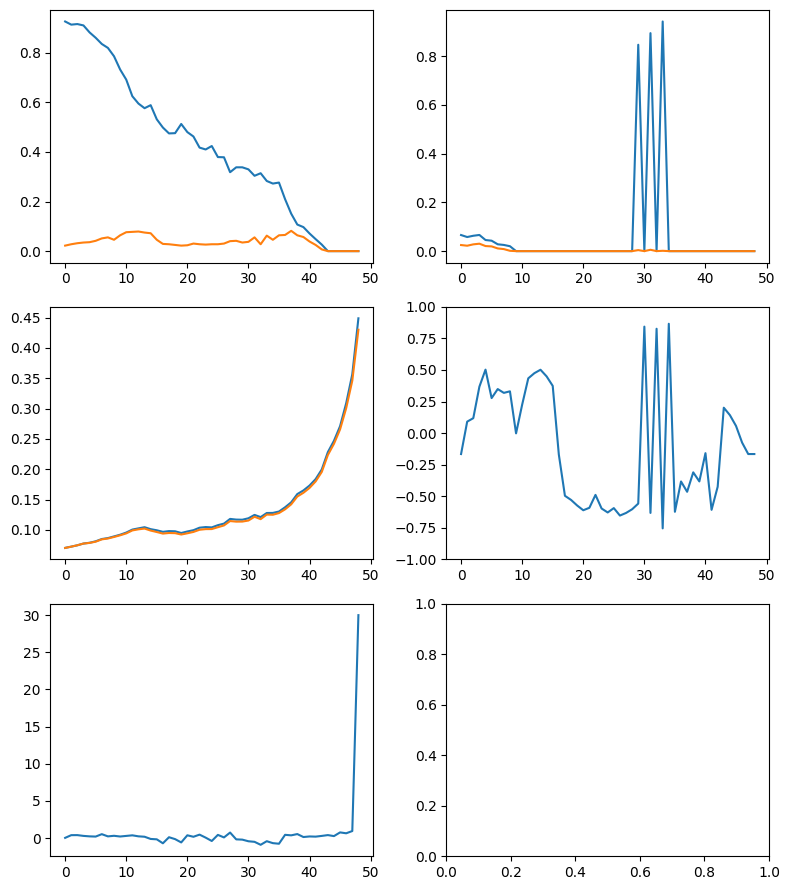

In [6]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 0)]),
    obstacle_radius=1,
    odor_source=np.array([[15, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0, 0, 0, 1),
)

sim = NMFNavigation(
    arena=arena,
    test_mode=True,
    debug_mode=True,
)

np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

start_from = "logs/trial_17d/trial_17d_117600_steps.zip"
train = False

log_dir = "logs/trial_8"
checkpoint_callback = callbacks.CheckpointCallback(
    save_freq=100,
    save_path=log_dir,
    name_prefix="trial_8",
    save_replay_buffer=True,
    save_vecnormalize=True,
    verbose=2,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC(
    "MlpPolicy",
    # env=sim,
    env=sim,
    policy_kwargs={"net_arch": [16, 16]},
    verbose=2,
    learning_rate=0.01,
)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=50_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/trial_8")

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(100):
    action, _ = model.predict(obs, deterministic=True)    
    obs, reward, terminated, truncated, info = sim.step(action)
    action_hist.append(action)
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video(Path(start_from).stem + ".mp4")

fig, axs = plt.subplots(3, 2, figsize=(8, 9), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 1].plot(obs_hist[:, 2])
axs[0, 1].plot(obs_hist[:, 3])
axs[1, 0].plot(obs_hist[:, 4])
axs[1, 0].plot(obs_hist[:, 5])
axs[1, 1].plot(action_hist)
axs[1, 1].set_ylim(-1, 1)
axs[2, 0].plot(reward_hist)

In [7]:
sample_interval = 30
individual_frames_dir = Path("outputs/individual_frames")
individual_frames_dir.mkdir(parents=True, exist_ok=True)

offset = max(0, len(sim._frames) % sample_interval - 1)
# print(len(sim._frames), offset)
selected_images = np.array(
    [sim._frames[i] for i in range(offset, len(sim._frames), sample_interval)]
)
background = np.median(np.array(sim._frames), axis=0)

for i in trange(0, selected_images.shape[0]):
    img = selected_images[i, :, :, :]
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    # break
    imageio.imwrite(
        individual_frames_dir / f"frame_{i}.png", img_alpha
    )

imageio.imwrite(individual_frames_dir / "background.png", background.astype(np.uint8))

100%|██████████| 5/5 [00:00<00:00, 46.10it/s]


In [8]:
len(sim._frames)

147

In [9]:
list(range(offset, len(sim._frames), sample_interval))

[26, 56, 86, 116, 146]